# モデルの評価と改良
モデルの評価とパラメータの選択について見ていく

In [18]:
# scoreメソッド: クラス分類に対して正しく分類されたサンプルの割合を計算
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# データセットの生成
X, y = make_blobs(random_state=0)
# 訓練セットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# モデルのインスタンスを生成し、訓練データで学習
logreg = LogisticRegression(solver="liblinear").fit(X_train, y_train)
# テストセットでモデルを評価
print(f"Test set score: {logreg.score(X_test, y_test):.2f}")

Test set score: 0.88


交差検証

汎化性能を評価する統計的手法で、ただ訓練セットとテストセットに分割する方法と比べて、より安定した手法。
データの分割を何度も行い、複数のモデルを訓練する。
最もよく用いられる交差検証手法は、**k分割交差検証(k-fold cross-validation)**→P.246

In [19]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import pandas as pd
import mglearn

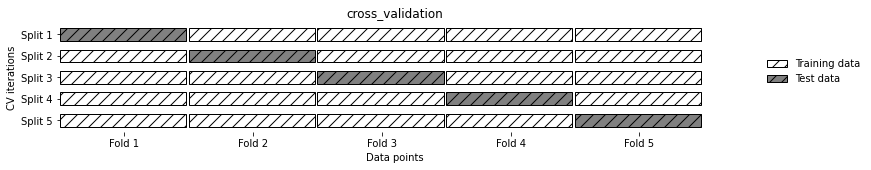

In [20]:
mglearn.plots.plot_cross_validation()

交差検証はscikit-learnではmodel_selectionモジュールの`cross_val_score`関数として実装されている。
評価したいモデルと、訓練データと、正解ラベルデータをパラメータとしている。

In [21]:
# irisデータセットをLogRegで評価
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression(solver="liblinear")

scores = cross_val_score(logreg, iris.data, iris.target)
print(f"Cross-validation scores: {scores}")

Cross-validation scores: [1.         0.96666667 0.93333333 0.9        1.        ]


In [22]:
# 精度をまとめるためには、一般に平均値を用いる
print(f"Average cross-validation score: {scores.mean():.2f}")
# 分割間でばらつきが比較的大きい→特定の分割に強く依存しているか、データセットのサイズが小さすぎるせいか？

Average cross-validation score: 0.96


交差検証の利点

- 全てのデータが必ず一度だけテストに用いられる→

    モデルはデータセットの全てのサンプルに対して良い汎化性能を示さなければ、交差検証スコアとその平均を高くすることができない。

- データの分割数を増やすと、訓練データセットに対する敏感さを知ることができる

    最悪の場合と最良の場合にどの程度の性能を示すかがわかる

欠点

- 計算コストが高い。

    k-個のモデルんを訓練するため、単純な分割の場合に比べておよそk倍遅くなる。

あくまでも交差検証の目的はどの程度汎化できるかを評価すること

In [23]:
# データセットの先頭から1/k個とる方法は、いつもうまくいくとも限らない
from sklearn.datasets import load_iris

iris = load_iris()
print(f"Iris labels:\n{iris.target}")
# これをそのまま分割すると、ひどいことになる

Iris labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


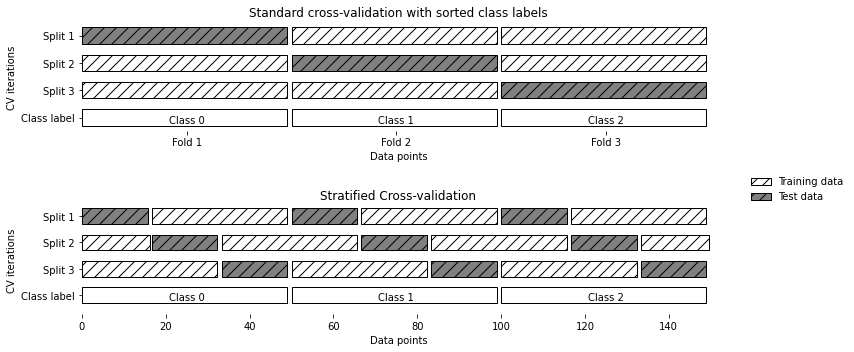

In [24]:
# scikit-learnでは、クラス分類ではデフォルトで層化k分割交差検証を用いる(stratified k-fold cross-validation)→分割内のクラスの比率が全体の比率と同じようになるように分割する。
mglearn.plots.plot_stratified_cross_validation()
# 回帰に関しては標準的なk分割交差検証を使っている

In [25]:
# 交差検証のより詳細な制御
# あえてクラス分類にk分割交差検証を使うときは、model_selectionモジュールからKFold分割器をインポートし、分割数を与えてインスタンスを生成
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

In [26]:
# cross_val_scoreにcvパラメータとして分割器オブジェクトを渡す
print(f"Cross-validation scores:\n{cross_val_score(logreg, iris.data, iris.target, cv=kfold)}")

Cross-validation scores:
[1.         0.93333333 0.43333333 0.96666667 0.43333333]


In [27]:
kfold = KFold(n_splits=3)
print(f"Cross-validation scores:\n{cross_val_score(logreg, iris.data, iris.target, cv=kfold)}")

Cross-validation scores:
[0. 0. 0.]


In [28]:
# 層化して分割する代わりに、データをシャッフルする方法もある。
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print(f"Cross-validation scores:\n{cross_val_score(logreg, iris.data, iris.target, cv=kfold)}")

Cross-validation scores:
[0.9  0.96 0.96]


1つ抜き交差検証(leave-one-out) P.251

大規模データだと時間がかかるが、小さいデータセットに対してはより良い推定が可能になる

In [29]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print(f"Number of cv iterations: {len(scores)}")
print(f"Mean accuracy: {scores.mean():.2f}")
# データ一つずつ検証するから、scoresは0,1の配列になる

Number of cv iterations: 150
Mean accuracy: 0.95


In [30]:
print(f"iris.data.shape: {iris.data.shape}")

iris.data.shape: (150, 4)


シャッフル分割交差検証(shuffle-split sross-validation) P.252

毎回train_size個の点を選んで訓練セットとし、test_size個の点(訓練セットと重複しない)を選んでテストセットとする。これをn_iter回繰り返す。

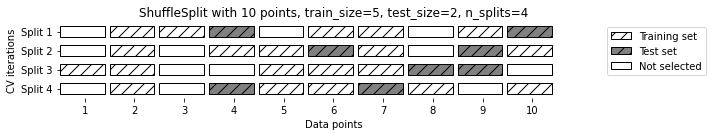

In [31]:
mglearn.plots.plot_shuffle_split()
# テストセットサイズ2 訓練セットサイズ5 4分割

In [32]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print(f"Cross-validation scores:\n{scores}")
# StratifiedShuffleSplitという層化バージョンもある

Cross-validation scores:
[0.94666667 0.90666667 0.94666667 0.94666667 0.96       0.90666667
 0.92       0.90666667 0.93333333 0.96      ]


グループ付き交差検証 P.253

In [33]:
# 12個のデータポイントと4つのグループを指定
from sklearn.model_selection import GroupKFold
# データセット生成
X, y = make_blobs(n_samples=12, random_state=0)
# 最初の3サンプル、4サンプル・・・を同じグループというようにする
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups, cv=GroupKFold(n_splits=3))
print(f"Cross-validation scores:\n{scores}")

Cross-validation scores:
[0.75       0.8        0.66666667]


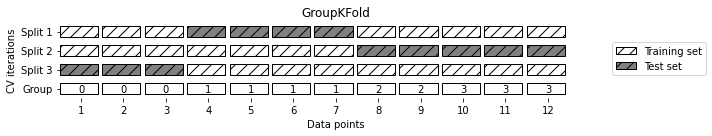

In [34]:
mglearn.plots.plot_group_kfold()

# グリッドサーチ P.254

最良の汎化性能を与える設定を探す

### 復習: RBFを用いたカーネル法を用いたSVMのパラメータ

gamma:大→個々のデータポイントを重視するように(モデルが複雑) ←gammaはカウシアンカーネルの幅の逆数だから

C:大→より正しくクラス分類されるように決定境界を曲げる(モデルが複雑)

In [35]:
# 単純なグリッドサーチ
# 0.001 0.01 0.1 1 10 100でC/gammaを変えてみる

# ナイーブなグリッドサーチ
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print(f"Size of training set: {X_train.shape[0]}  size of test set: {X_test.shape[0]}")

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # それぞれのパラメータの組み合わせに対してSVCを訓練
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # SVCをテストセットで評価
        score = svm.score(X_test, y_test)
        # 良いスコアだったらパラメータとスコアを保存
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print(f"Best score: {best_score:.2f}")
print(f"Best parameters: {best_parameters}")

Size of training set: 112  size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


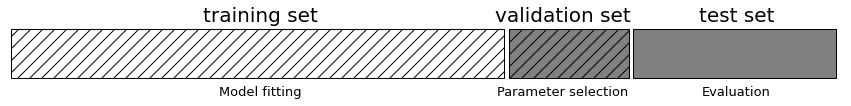

In [37]:
mglearn.plots.plot_threefold_split()

In [39]:
from sklearn.svm import SVC
# データを訓練+検証セットとテストセットに分割
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
# 訓練+検証セットを訓練セットと検証セットに分割
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
print(f"Size of training set: {X_train.shape[0]}, size of validation set: {X_valid.shape[0]}, size of test set: {X_test.shape[0]}")

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # それぞれのパラメータの組み合わせに対してSVCを訓練
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # SVCを検証セットで評価
        score = svm.score(X_valid, y_valid)
        # 良いスコアだったらパラメータとスコアを保存
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# 訓練セットと検証セットを用いてモデルを再構築し、テストセットで評価
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)

print(f"Best score on validation set: {best_score:.2f}")
print(f"Best parameters: {best_parameters}")
print(f"Test set score with best parameters: {test_score:.2f}")
# 新しいデータに対する精度として主張できるのは、92%となる

Size of training set: 84, size of validation set: 28, size of test set: 38
Best score on validation set: 0.96
Best parameters: {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


訓練セット、検証セット、テストセットを区別することは重要

In [42]:
best_score = 0
# 汎化性能をよりよく見積もるために、それぞれのパラメータの組み合わせに対して交差検証を行う
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        # 交差検証を行う 5分割→5回繰り返しスコアを計算
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # 交差検証精度の平均値を計算
        score = np.mean(scores)
        # 良いスコアがでたら、スコアとパラメータを記録
        if score > best_score:
            best_score = score
            best_parameter = {'C': C, 'gamma': gamma}
# 訓練セットと検証セットを合わせてモデルを再構築
svm = SVC(**best_parameter)
svm.fit(X_trainval, y_trainval)
# 36 * 5で180通りのモデルを訓練するため、時間がかかる

SVC(C=10, gamma=0.1)

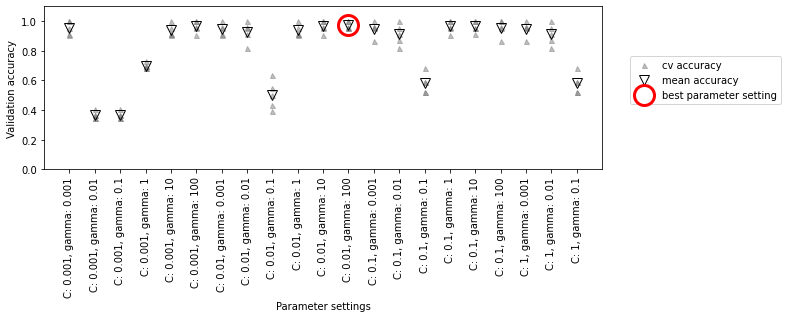

In [43]:
# 最良のパタメータ設定が選択される様子
mglearn.plots.plot_cross_val_selection()

交差検証は元々評価の方法だが、パラメータ検索方法と共に使われることが多い。このため、多くの人が「交差検証を用いたグリッドサーチ」をさして交差検証という言葉を使っている

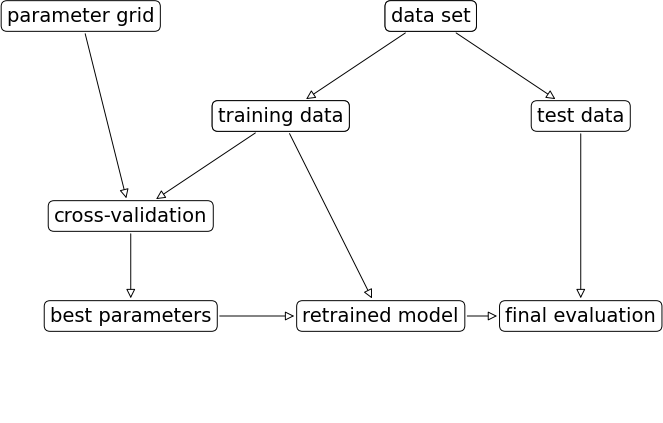

In [44]:
# データの分割→グリッドサーチ→最後のパラメータを評価する過程
mglearn.plots.plot_grid_search_overview()

交差検証を用いたグリッドサーチは、GridSearchCVクラスが提供されている

In [46]:
# ディクショナリを用いて探索したいパラメータを指定
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print(f"Parameter grid:\n{param_grid}")

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [47]:
# GridSearchCVクラスをモデル(SVC)、サーチすべきパラメータのグリッド(param_grid)、使用したい交差検証戦略(例えば5分割層化交差検証)を指定してインスタンスを生成
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

grid_search = GridSearchCV(SVC(), param_grid, cv=5)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

In [49]:
# grid_searchオブジェクトは通常のクラス分類器と同じように振舞う。→fit predict, scoreメソッドが呼べる
grid_search.fit(X_train, y_train)
# fitによって交差検証で最も良いスコアだったパラメータを用いて、自動的に訓練セット全体に対して新しいモデルを学習してくれる

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

In [50]:
# GridSearchCVクラスで得られたモデルは。predict/scoreメソッドで簡単にアクセスできる
print(f"Test set score: {grid_search.score(X_test, y_test):.2f}")
# ベストなパラメータを選ぶ時に重要なのはテストセットを使わなかったこと

Test set score: 0.97


In [51]:
# 見つけたパラメータはbest_params_属性に、交差検証精度はbest_score_属性に格納される
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")
# あくまでもbest_scoreとscoreメソッドをテストセットに対して呼び出した値は別物

Best parameters: {'C': 10, 'gamma': 0.1}
Best cross-validation score: 0.97


In [54]:
# 実際のモデルの係数や特徴量の重要性を見たい時は、best_estimator_属性を用いてアクセスすることができる
print(f"Best estimator:\n{grid_search.best_estimator_}")

Best estimator:
SVC(C=10, gamma=0.1)


In [55]:
# グリッドサーチの結果はcv_results_属性に格納される
import pandas as pd
# DataFrameへ変換
results = pd.DataFrame(grid_search.cv_results_)
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000706,0.000133,0.000378,0.000058,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
1,0.000992,0.000110,0.000501,0.000116,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
2,0.001028,0.000188,0.000610,0.000166,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
3,0.000833,0.000179,0.000472,0.000143,0.001,1,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
4,0.000725,0.000128,0.000415,0.000063,0.001,10,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22


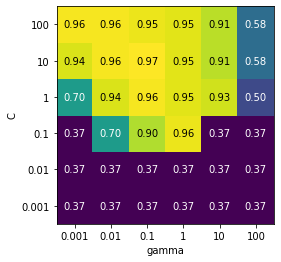

In [57]:
# 2次元のパラメータグリッドを探索してるからヒートマップで可視化してみる
# 平均検証スコアを抽出し、軸がCとgammaになるように変形
scores = np.array(results.mean_test_score).reshape(6, 6)

# 平均交差検証スコアのプロット
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'], ylabel='C', yticklabels=param_grid['C'], cmap="viridis")
# SVCはパラメータに敏感であることがわかる。さらに、レンジは広く取っておいた方が良い

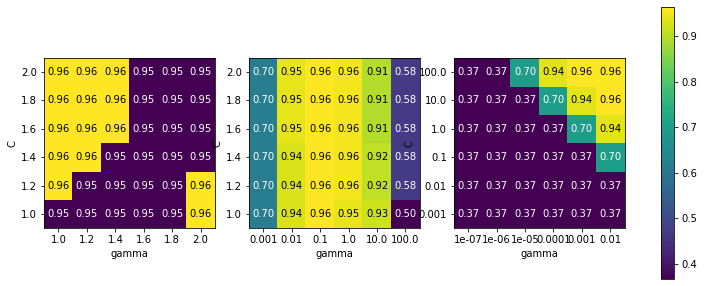

In [59]:
# 悪い例
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
param_grid_linear = {'C': np.linspace(1, 2, 6), 'gamma': np.linspace(1, 2, 6)}

param_grid_one_log = {'C': np.linspace(1, 2, 6), 'gamma': np.logspace(-3, 2, 6)}

param_grid_range = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)

    # 平均交差検証精度をプロット
    scores_image = mglearn.tools.heatmap(scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'], yticklabels=param_grid['C'], cmap="viridis", ax=ax)

plt.colorbar(scores_image, ax=axes.tolist())
# 左を見ると、レンジが小さいorパラメータが重要ではない(?)かがわかる
# 真ん中をみると、gammaだけが精度に影響してそう。Cは適切にサーチできていないor Cは重要ではない(?)
# 右を見ると、左下では特に変化がない。レンジを変更してより多くの範囲を含むようにしてみるべき

In [60]:
# kernelがlinearかrbfかで条件をつけた、グリッドではないサーチ空間で探索できる
# カーネルとパラメータの組み合わせに対するグリッドサーチ
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print(f"List of grids:\n{param_grid}")

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In [61]:
# グリッドサーチの適用
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.97


In [62]:
# cv_results_を見てみる。kernelはlinear部分でCだけ変化してるのが確認できる
results = pd.DataFrame(grid_search.cv_results_)

# 表示の都合上テーブルを転置
display(results.T)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.00117936,0.000836134,0.000888014,0.000733185,0.000764799,0.000605965,0.000603724,0.000592184,0.000628185,0.000557613,...,0.000389814,0.000556135,0.000720692,0.00125775,0.000594664,0.000783062,0.000790834,0.000503826,0.000448513,0.000634193
std_fit_time,0.000207781,0.000136236,0.000100792,0.000132384,0.000104758,6.26813e-05,6.05524e-05,5.63779e-05,5.53302e-05,1.71995e-05,...,1.95468e-05,5.16088e-05,5.56147e-05,0.000232884,0.000123789,0.000176325,5.94224e-05,0.000133293,1.86164e-05,8.6126e-05
mean_score_time,0.000580597,0.00047226,0.000470877,0.000485039,0.000376987,0.000359821,0.000314379,0.000303364,0.000374174,0.000289869,...,0.000262785,0.000312376,0.000310659,0.000516081,0.000325775,0.000468922,0.000522804,0.000304031,0.000280142,0.000352287
std_score_time,0.000151344,0.000110881,8.97356e-05,0.000152354,6.13268e-05,9.36315e-05,4.35064e-05,2.31178e-05,7.98718e-05,1.33943e-05,...,4.03879e-06,4.00507e-05,4.78066e-05,0.000110953,7.96477e-05,4.3174e-05,4.1828e-05,3.25737e-05,7.39482e-06,6.2976e-05
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1,0.956522,0.869565,0.521739,0.347826,0.869565,1,1,1,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,0.956522,0.956522,0.913043,0.521739,0.347826,0.869565,0.913043,0.956522,1,0.956522


デフォルトではクラス分類には層化k分割、回帰にはk分割交差検証が用いられるが、cvパラメータに分割器を渡すことができる。

訓練セットと検証セットへの分割を一度だけにするには、ShuffleSplitもしくはStratifiedShuffleSplitを用いてn_iter=1とすると良い。

データセットが大きい場合や、モデルの計算に時間がかかる場合に有用。

# ネストした交差検証 P.267

データを訓練セットとテストセットに一度だけ分けるだけでなく、交差検証で何度も分割することを考える

未来のデータに適用するための予測モデルを探すのではなく、あるモデルのあるデータセットに対する性能の評価に対して有用

cross_val_scoreをGridSearchCVのインスタンスをモデルとして呼べば良い。

In [63]:
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5), iris.data, iris.target, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")
# →「SVCはirisデータセットに対して交差検証精度の平均で97%を達成することができる」と言える
# 36 * 5(外側の5分割) * 5(内側の5分割) = 900通りのモデルが構築された

Cross-validation scores: [0.96666667 1.         0.9        0.96666667 1.        ]
Mean cross-validation score: 0.9666666666666668


In [66]:
# 交差検証の分割数は内側と外側で同じである必要はない。
# forループを使ってわかりやすく記述
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    # 外側の交差検証による個々の分割に対するループ
    # splitはメソッドはインデックスを返す
    for training_samples, test_samples in outer_cv.split(X, y):
        # 内側の交差検証を用いて最良のパラメータ設定を見つける
        best_params = {}
        best_score = -np.inf
        # 個々のパラメータ設定に対してループ
        for parameters in parameter_grid:
            # 内側の分割に対するスコアを格納
            cv_scores = []
            # 内側の交差検証のループ
            for inner_train, inner_test in inner_cv.split(X[training_samples], y[training_samples]):
                # 与えられたパラメータと訓練セットでクラス分類器を訓練
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                # 内側のテストセットを評価
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            # 内側の分割に対するスコアの平均を算出
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # これまでのよりよければ、パラメータを記憶
                best_score = mean_score
                best_params = parameters
        # 最良のパラメータセットと外側の訓練セットを用いてクラス分類器を構築
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        # 評価
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

```python
>>> ary = np.arange(1, 10, 2)
>>> ary
array([1, 3, 5, 7, 9])
>>> ary[[0, 2]]
array([1, 5])
```

In [68]:
# irisデータセットに対して実行
from sklearn.model_selection import ParameterGrid, StratifiedKFold
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5), StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print(f"Cross-validation scores: {scores}")

Cross-validation scores: [0.96666667 1.         0.96666667 0.96666667 1.        ]


グリッドサーチは単純並列(embrrassingly paralell)であるから、パラメータ設定や分割に対して独立に実行できる。GridSearchCVとcross_val_scoreでは、パラメータ`n_jobs`に利用したいコア数を設定することで、複数のコアを利用することができる。

scikit-learnではネストした並列実行はサポートしていない→例えば、ランダムフォレストでn_jobsオプションを使っていたら、GridSearchCVでは使うことができない。

詳しくはP.269

# 評価基準とスコア P.270

## エラーの種類
２クラス分類では、主に陽性と陰性に分けられる。その中で、間違った陽性を「偽陽性」といい、間違った陰性を「偽陰性」と言われる。

例えば、ガンの診断では、偽陽性はさらなる検査をさせられるだけだが、偽陰性は次に必要な検査や治療が受けられなくなるリスクが存在する。

アプリケーションの評価は精度(正確に分類できた割合)ではなく、損失額などの重みをつけた評価もすることができる。

## 偏ったデータセット
一方のクラスが他方のクラスよりもずっと多いようなデータセットを偏ったデータセット(imbalanced datasets)という。

例: 広告のクリック予測

偏ったデータセットに対しては、精度という基準では常に「クリックされない」と返すモデルと、潜在的には良いモデルを区別できない。

In [69]:
# digitsデータセットで9と9意外に分割する問題
from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

In [70]:
# DummyClassifierを常に多数のクラス(9以外)を予測するようにして、精度が役に立たないことを確かめる
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print(f"Unique predicted labels: {np.unique(pred_most_frequent)}")
print(f"Test score: {dummy_majority.score(X_test, y_test):.2f}")
# 何も学習しなくても、Falseと言うだけで90%の精度が得られた

Unique predicted labels: [False]
Test score: 0.90


In [72]:
# 実際のクラス分類器で比較
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print(f"Test score: {tree.score(X_test, y_test):.2f}")

Test score: 0.92


In [73]:
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print(f"Dummy score: {dummy.score(X_test, y_test):.2f}")

logreg = LogisticRegression(solver='liblinear', C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print(f"logreg score: {logreg.score(X_test, y_test):.2f}")
# 偏ったデータに対する予測性能を定量化する基準として、精度は不適切

Dummy score: 0.81
logreg score: 0.98


## 混同行列
2クラス分類評価結果を表現する方法で、最も包括的な方法の一つとして混合行列(confusion matrix)がある。

In [74]:
# logregの結果をconfusion_matrix関数で見てみる
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print(f"COnfusion matrix:\n{confusion}")
# 行は実際のクラスに対応し、列は予測されたクラスに対応

COnfusion matrix:
[[401   2]
 [  8  39]]


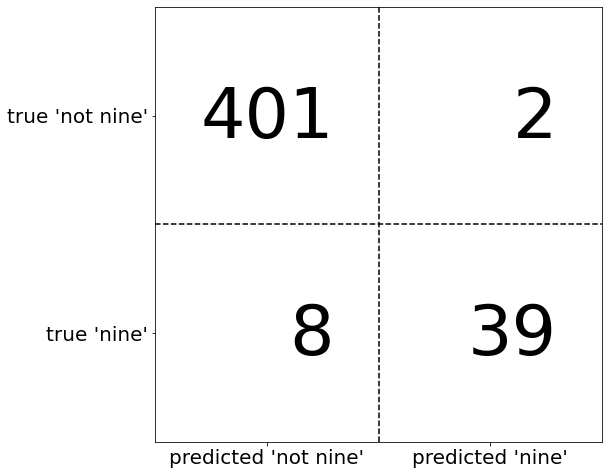

In [75]:
mglearn.plots.plot_confusion_matrix_illustration()
# 主対角成分の要素は正確に分類されたサンプルの数を示す

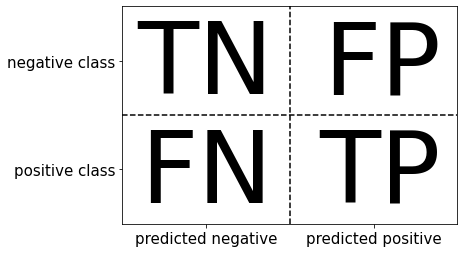

In [76]:
mglearn.plots.plot_binary_confusion_matrix()

In [77]:
# それぞれの結果を混合行列を用いてみる
print("Most frequent class:")
print(confusion_matrix(y_test, pred_most_frequent))
print("\nDummy model:")
print(confusion_matrix(y_test, pred_dummy))
print("\nDecision tree:")
print(confusion_matrix(y_test, pred_tree))
print("\nLogistic Regression:")
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Dummy model:
[[376  27]
 [ 45   2]]

Decision tree:
[[390  13]
 [ 24  23]]

Logistic Regression:
[[401   2]
 [  8  39]]


混合行列の結果をまとめる手法→P.277

In [78]:
# f1-値(P.278)を予想結果に適用してみる
from sklearn.metrics import f1_score
print(f"f1 score most frequent: {f1_score(y_test, pred_most_frequent):.2f}")
print(f"f1 score most dummy: {f1_score(y_test, pred_dummy):.2f}")
print(f"f1 score most tree: {f1_score(y_test, pred_tree):.2f}")
print(f"f1 score most logreg: {f1_score(y_test, pred_logreg):.2f}")

f1 score most frequent: 0.00
f1 score most dummy: 0.05
f1 score most tree: 0.55
f1 score most logreg: 0.89


In [80]:
# 適合率、再現率、f-値をまとめたレポートを得るには、classification_report関数を使う
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_most_frequent, target_names=["not nine", "nine"]))
# クラスごとに、そのクラスを陽性とした場合の値を示している
# 支持度: そのクラスの実際のサンプルの個数

precision    recall  f1-score   support

    not nine       0.90      1.00      0.94       403
        nine       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



In [81]:
print(classification_report(y_test, pred_dummy, target_names=["not nine", "nine"]))

precision    recall  f1-score   support

    not nine       0.89      0.93      0.91       403
        nine       0.07      0.04      0.05        47

    accuracy                           0.84       450
   macro avg       0.48      0.49      0.48       450
weighted avg       0.81      0.84      0.82       450



In [82]:
print(classification_report(y_test, pred_logreg, target_names=["not nine", "nine"]))
# どのクラスを陽性とするかによって値が大きく変わる。全ての値を合わせてみると、かなり正確な様子が掴める。

precision    recall  f1-score   support

    not nine       0.98      1.00      0.99       403
        nine       0.95      0.83      0.89        47

    accuracy                           0.98       450
   macro avg       0.97      0.91      0.94       450
weighted avg       0.98      0.98      0.98       450



In [83]:
from mglearn.datasets import make_blobs
X, y = make_blobs(n_samples=(450, 50), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)

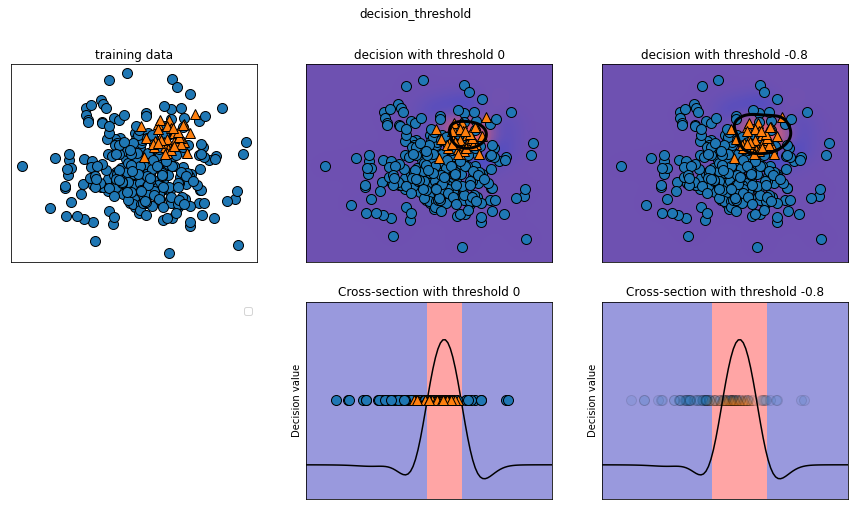

In [84]:
mglearn.plots.plot_decision_threshold()

In [85]:
print(classification_report(y_test, svc.predict(X_test)))

precision    recall  f1-score   support

           0       0.93      0.97      0.95       116
           1       0.25      0.11      0.15         9

    accuracy                           0.91       125
   macro avg       0.59      0.54      0.55       125
weighted avg       0.88      0.91      0.90       125



In [86]:
# クラス1の再現率を高めるため、決定スレッショルドを0(デフォルト)から小さくする
y_pred_lower_threshold = svc.decision_function(X_test) > -.8

In [87]:
print(classification_report(y_test, y_pred_lower_threshold))

precision    recall  f1-score   support

           0       0.97      0.96      0.97       116
           1       0.55      0.67      0.60         9

    accuracy                           0.94       125
   macro avg       0.76      0.81      0.78       125
weighted avg       0.94      0.94      0.94       125



データが偏っている場合、適合率or再現率のどちらかを重視したい場合は、決定スレッショルドを変更すること。

本来はテストセットではなく検証セットを使って設定するべき(テストセットを用いると楽観的な結果になる)。それか交差検証を使うこと！

predict_probaはデフォルトで0.5→50%以上確かなら、陽性クラスに分類。

しかし、全てのモデルが現実的な確信度モデルを持つわけではない(深さ制限をつけずに訓練したDecisionTreeは、間違っていることがあるにもかかわらず、常に100%確実だと判断する)

ここで出てくるのが較正(calibration)。詳しくはP.283

# 適合率-再現率カーブとROCカーブ

指定の再現率・適合率にスレッショルドを調整するために、全ての可能なスレッショルド(適合率と再現率の組み合わせ)を同時にみることが役にたつ。

適合率-再現率カーブ(precision-recall curve)と言うのを用いる。
実際のラベル情報と、decision_functionかpredict_probaで予測された不確実性を必要とする。

In [90]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

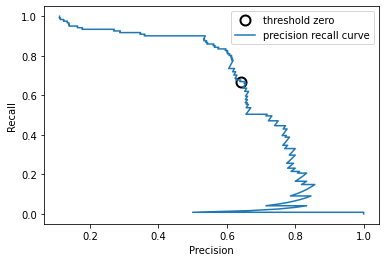

In [91]:
# 全ての可能なスレッショルドに対する適合率と再現率の値のリストをソートして返すから、プロットできる
# カーブが滑らかになるようにデータポイントを増やす
X, y = make_blobs(n_samples=(4000, 500), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))
# ゼロに最も近いスレッショルドを探す
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c="k", mew=2)

plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")
# カーブが右上の角に近ければ近いほど、良いクラス分類器と言える→P.285

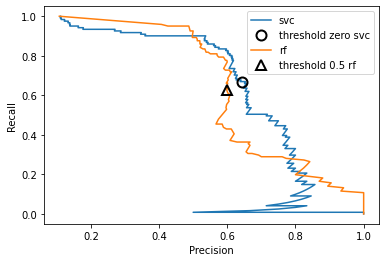

In [94]:
# 得意とするカーブの部分、動作ポイントはクラス分類器によって異なる。ランダムフォレストを用いて比較してみる
# RandomForestにはpredict_probaしかなく、precision_recall_curve関数の第二引数には陽性クラス(クラス1)の確信度尺度だから、サンプルがクラス1になる確率を渡せば良い
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

# rfにはpredict_probaはあるが、decision_functionはない
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(precision, recall, label='svc')

plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label='threshold zero svc', fillstyle='none', c='k', mew=2)

plt.plot(precision_rf, recall_rf, label='rf')
# predict_provaのデフォルトは0.5 P.283
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k', markersize=10, label='threshold 0.5 rf', fillstyle='none', mew=2)

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")
# 非常に高い再現率や非常に高い適合率が要求される場合には、ランダムフォレストの性能が良い

In [96]:
print(f"f1_score of random forest: {f1_score(y_test, rf.predict(X_test)):.3f}")
print(f"f1_score of svc: {f1_score(y_test, svc.predict(X_test)):.3f}")

f1_score of random forest: 0.610
f1_score of svc: 0.656


自動的にコンピュータでモデルを比較するには、カーブの情報を数値化する必要がある→カーブ下の領域を積分する。

**平均適合率(avarage precision)**とも呼ばれる。`avarage_precision_score`関数を用いて平均適合率を計算することができる。

適合率-再現率カーブを計算して複数のスレッショルドを考えるため、predoctの結果ではなく、decision_functionまたはpredict_probaの結果を渡す。

In [98]:
from sklearn.metrics import average_precision_score
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
print(f"Average precision of random forest: {ap_rf:.3f}")
print(f"Average precision of svc: {ap_svc:.3f}")

Average precision of random forest: 0.660
Average precision of svc: 0.666


# ROCとAUC P.288

様々なスレッショルドにおけるクラス分類器の挙動を解析するための道具として、受信者動作特性カーブ(receiver operating charactristic:ROC)カーブと言うのがある。適合率-再現率の代わりに、偽陽性率(FPR: 全ての陰性サンプルに対する偽陽性の割合)を真陽性率(TPR: 全ての陽性サンプルに対する陽性と判断された割合。再現率)に対してプロットする。

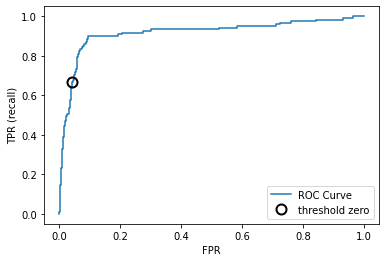

In [99]:
# ROCの計算
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# 0に最も近いスレッショルドを見つける
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label="threshold zero", fillstyle='none', c='k', mew=2)
plt.legend(loc=4)
# 理想的な点は左上に近い点→低い偽陽性率を保ちながら高い再現率を達成するもの
# 実際にはテストセットではなく検証セットを用意しておくこと！


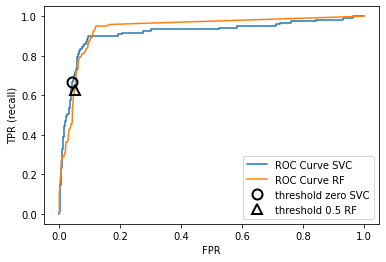

In [101]:
# svcとランダムフォレストの比較
from sklearn.metrics import roc_curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label="threshold zero SVC", fillstyle='none', c='k', mew=2)
# predict_provaのデフォルトは0.5 P.283
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], 
         '^', markersize=10, label="threshold 0.5 RF", fillstyle='none', c='k', mew=2)
plt.legend(loc=4)

適合率-再現率カーブと同様に、カーブ下の領域面積を用いてROCカーブを一つの値で表現できる。
カーブ下の領域(area under the curve)で略してAUCと言う。

`roc_auc_score`で計算できる


In [103]:
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))

print(f"AUC for Random Forest: {rf_auc:.3f}")
print(f"AUC for SVC: {svc_auc:.3f}")

AUC for Random Forest: 0.937
AUC for SVC: 0.916


gamma = 1.00  accuracy = 0.90  AUC = 0.500
gamma = 0.05  accuracy = 0.90  AUC = 0.999
gamma = 0.01  accuracy = 0.90  AUC = 1.000


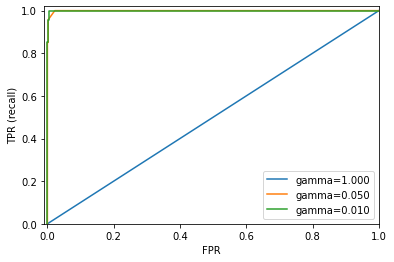

In [104]:
# digitsデータセットの問題で、SVMのカーネルバンド幅gamma を3種類にしてデータセットを分類
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

plt.figure()

for gamma in [1, 0.05, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test, svc.decision_function(X_test))
    print(f"gamma = {gamma:.2f}  accuracy = {accuracy:.2f}  AUC = {auc:.3f}")
    plt.plot(fpr, tpr, label=f'gamma={gamma:.3f}')
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc='best')
# gamma=1の場合はランダムなものと変わらない。
# 0.01では、AUC=1となっている→全ての陽性データポイントが、全ての陰性データポイントよりも決定関数で良いスコアを得ている。

偏ったデータセットを評価する時には、AUCを使うと良い。

AUCはデフォルトのスレッショルドを用いないから、有用なクラス分類のためにはスレッショルドを調整する必要がある。

# 多クラス分類の基準 P.292

一般的な評価ツールは、混合行列とクラス分類レポートがある

In [105]:
from sklearn.metrics import accuracy_score # 3章で出てきた
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
pred = lr.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, pred):.3f}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, pred)}")
# うまく機能してそう

Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


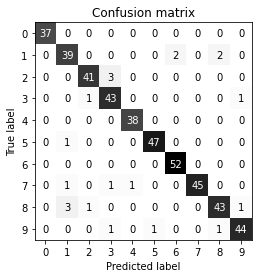

In [108]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, pred), xlabel='Predicted label', ylabel='True label', xticklabels=digits.target_names,
    yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [109]:
# 適合率、再現率、f-値をそれぞれのクラスに対して計算
print(classification_report(y_test, pred))

precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.91      0.90        43
           2       0.95      0.93      0.94        44
           3       0.90      0.96      0.92        45
           4       0.97      1.00      0.99        38
           5       0.98      0.98      0.98        48
           6       0.96      1.00      0.98        52
           7       1.00      0.94      0.97        48
           8       0.93      0.90      0.91        48
           9       0.96      0.94      0.95        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



## 多クラスf-値の計算方法

偏ったデータセットに対する多クラス問題で用いられる基準

まず、個々のクラスに対して陽性・その他を陰性とした２クラスf-値を計算する→クラスごとのf-値を以下の方法で平均する

- macro平均: 重みをつけずにクラスごとのf値を平均する

- weighted平均: 各クラスの支持度に応じて重みをつけてクラスごとのf値を平均する

- micro平均: 全てのクラスの偽陽性、偽陰性、真陽性の総数を計算し、その値を用いて適合率、再現率、f-値を計算

個々の**サンプル**を同じように重視するなら`micro`平均のf-値を使い、個々の**クラス**を同じように重視するなら、`macro`平均のf-値を使う

In [125]:
# ""で囲まれてるから、average=""とかくとsyntax errorが起こる
print(f"Micro average f1 score: {f1_score(y_test, pred, average='micro'):.3f}")
print(f"Macro average f1 score: {f1_score(y_test, pred, average='macro'):.3f}")

Micro average f1 score: 0.953
Macro average f1 score: 0.954


# 回帰の基準 P.295

基本的にはR^2スコアが最も直感的

AUCのような基準を、GridSearchCVやcross_val_scoreによるモデル選択で用いることができる。

scoring引数に利用したい評価基準を文字列で与えるだけで良い。

In [130]:
# デフォルトのクラス分類スコアは精度
print(f"Default scoring: {cross_val_score(SVC(), digits.data, digits.target == 9, cv=3)}")
# scoring="accuracy"としても結果は変わらない explicit:明示的
explicit_accuracy = cross_val_score(SVC(), digits.data, digits.target == 9, scoring='accuracy', cv=3)
print(f"Explicit accuracy scoring: {explicit_accuracy}")
roc_auc = cross_val_score(SVC(), digits.data, digits.target == 9, scoring='roc_auc', cv=3)
print(f"AUC scoring: {roc_auc}")

Default scoring: [0.97996661 0.98664441 0.98330551]
Explicit accuracy scoring: [0.97996661 0.98664441 0.98330551]
AUC scoring: [0.99557823 0.99879406 0.98964131]


In [131]:
# 同様にGridSearchCVで最良のパラメータを見つける基準にも使える
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target == 9, random_state=0)

# 説明の都合上、あまり良くないグリッドを与える
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)
print("Grid-Search with accuracy")
print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation score (accuracy): {grid.best_score_:.3f}")
print(f"Test set AUC: {roc_auc_score(y_test, grid.decision_function(X_test)):.3f}")
print(f"Test set accuracy: {grid.score(X_test, y_test):.3f}")

Grid-Search with accuracy
Best parameters: {'gamma': 0.0001}
Best cross-validation score (accuracy): 0.976
Test set AUC: 0.992
Test set accuracy: 0.973


In [132]:
# AUCをスコアに用いる
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring='roc_auc')
grid.fit(X_train, y_train)
print("Grid-Search with AUC")
print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation score (AUC): {grid.best_score_:.3f}")
print(f"Test set AUC: {grid.score(X_test, y_test):.3f}")

Grid-Search with AUC
Best parameters: {'gamma': 0.01}
Best cross-validation score (AUC): 0.998
Test set AUC: 1.000


使えるscoringパラメータの種類→P.297

In [133]:
from sklearn.metrics.scorer import SCORERS
print(f"Average scorers:\n{SCORERS.keys()}")

Average scorers:
dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])
